# <p><center style="font-family:newtimeroman;font-size:180%;">Выявление и оценка болезни Альцгеймера с помощью анализа изображений сетью InceptionV3</center></p>
### Table of contents:

* [Импорт библиотек](#1)
* [Загрузка данных](#2)
* [Визуализация набора данных](#3)
* [Исследование данных](#4)
* [InceptionV3 Модель](#10)
* [Оценка модели](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Импорт библиотек </p>
<a class="btn" href="#home">Содержание</a>

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Загрузка данных</p>
<a class="btn" href="#home">Содержание</a>

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented

[6400 rows x 2 columns]

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Визуализация данных</p>
<a class="btn" href="#home">Содержание</a>

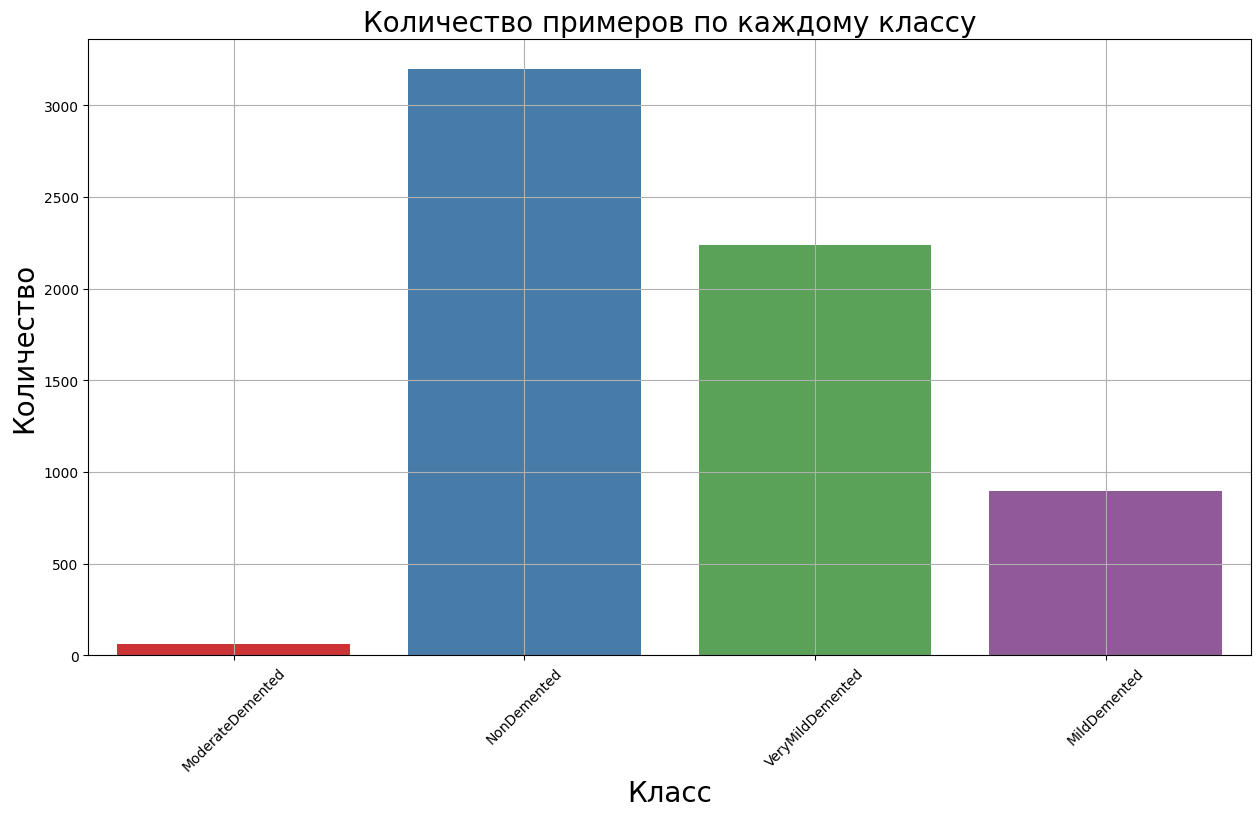

In [3]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Класс",fontsize=20)
ax.set_ylabel("Количество",fontsize=20)
plt.title('Количество примеров по каждому классу',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

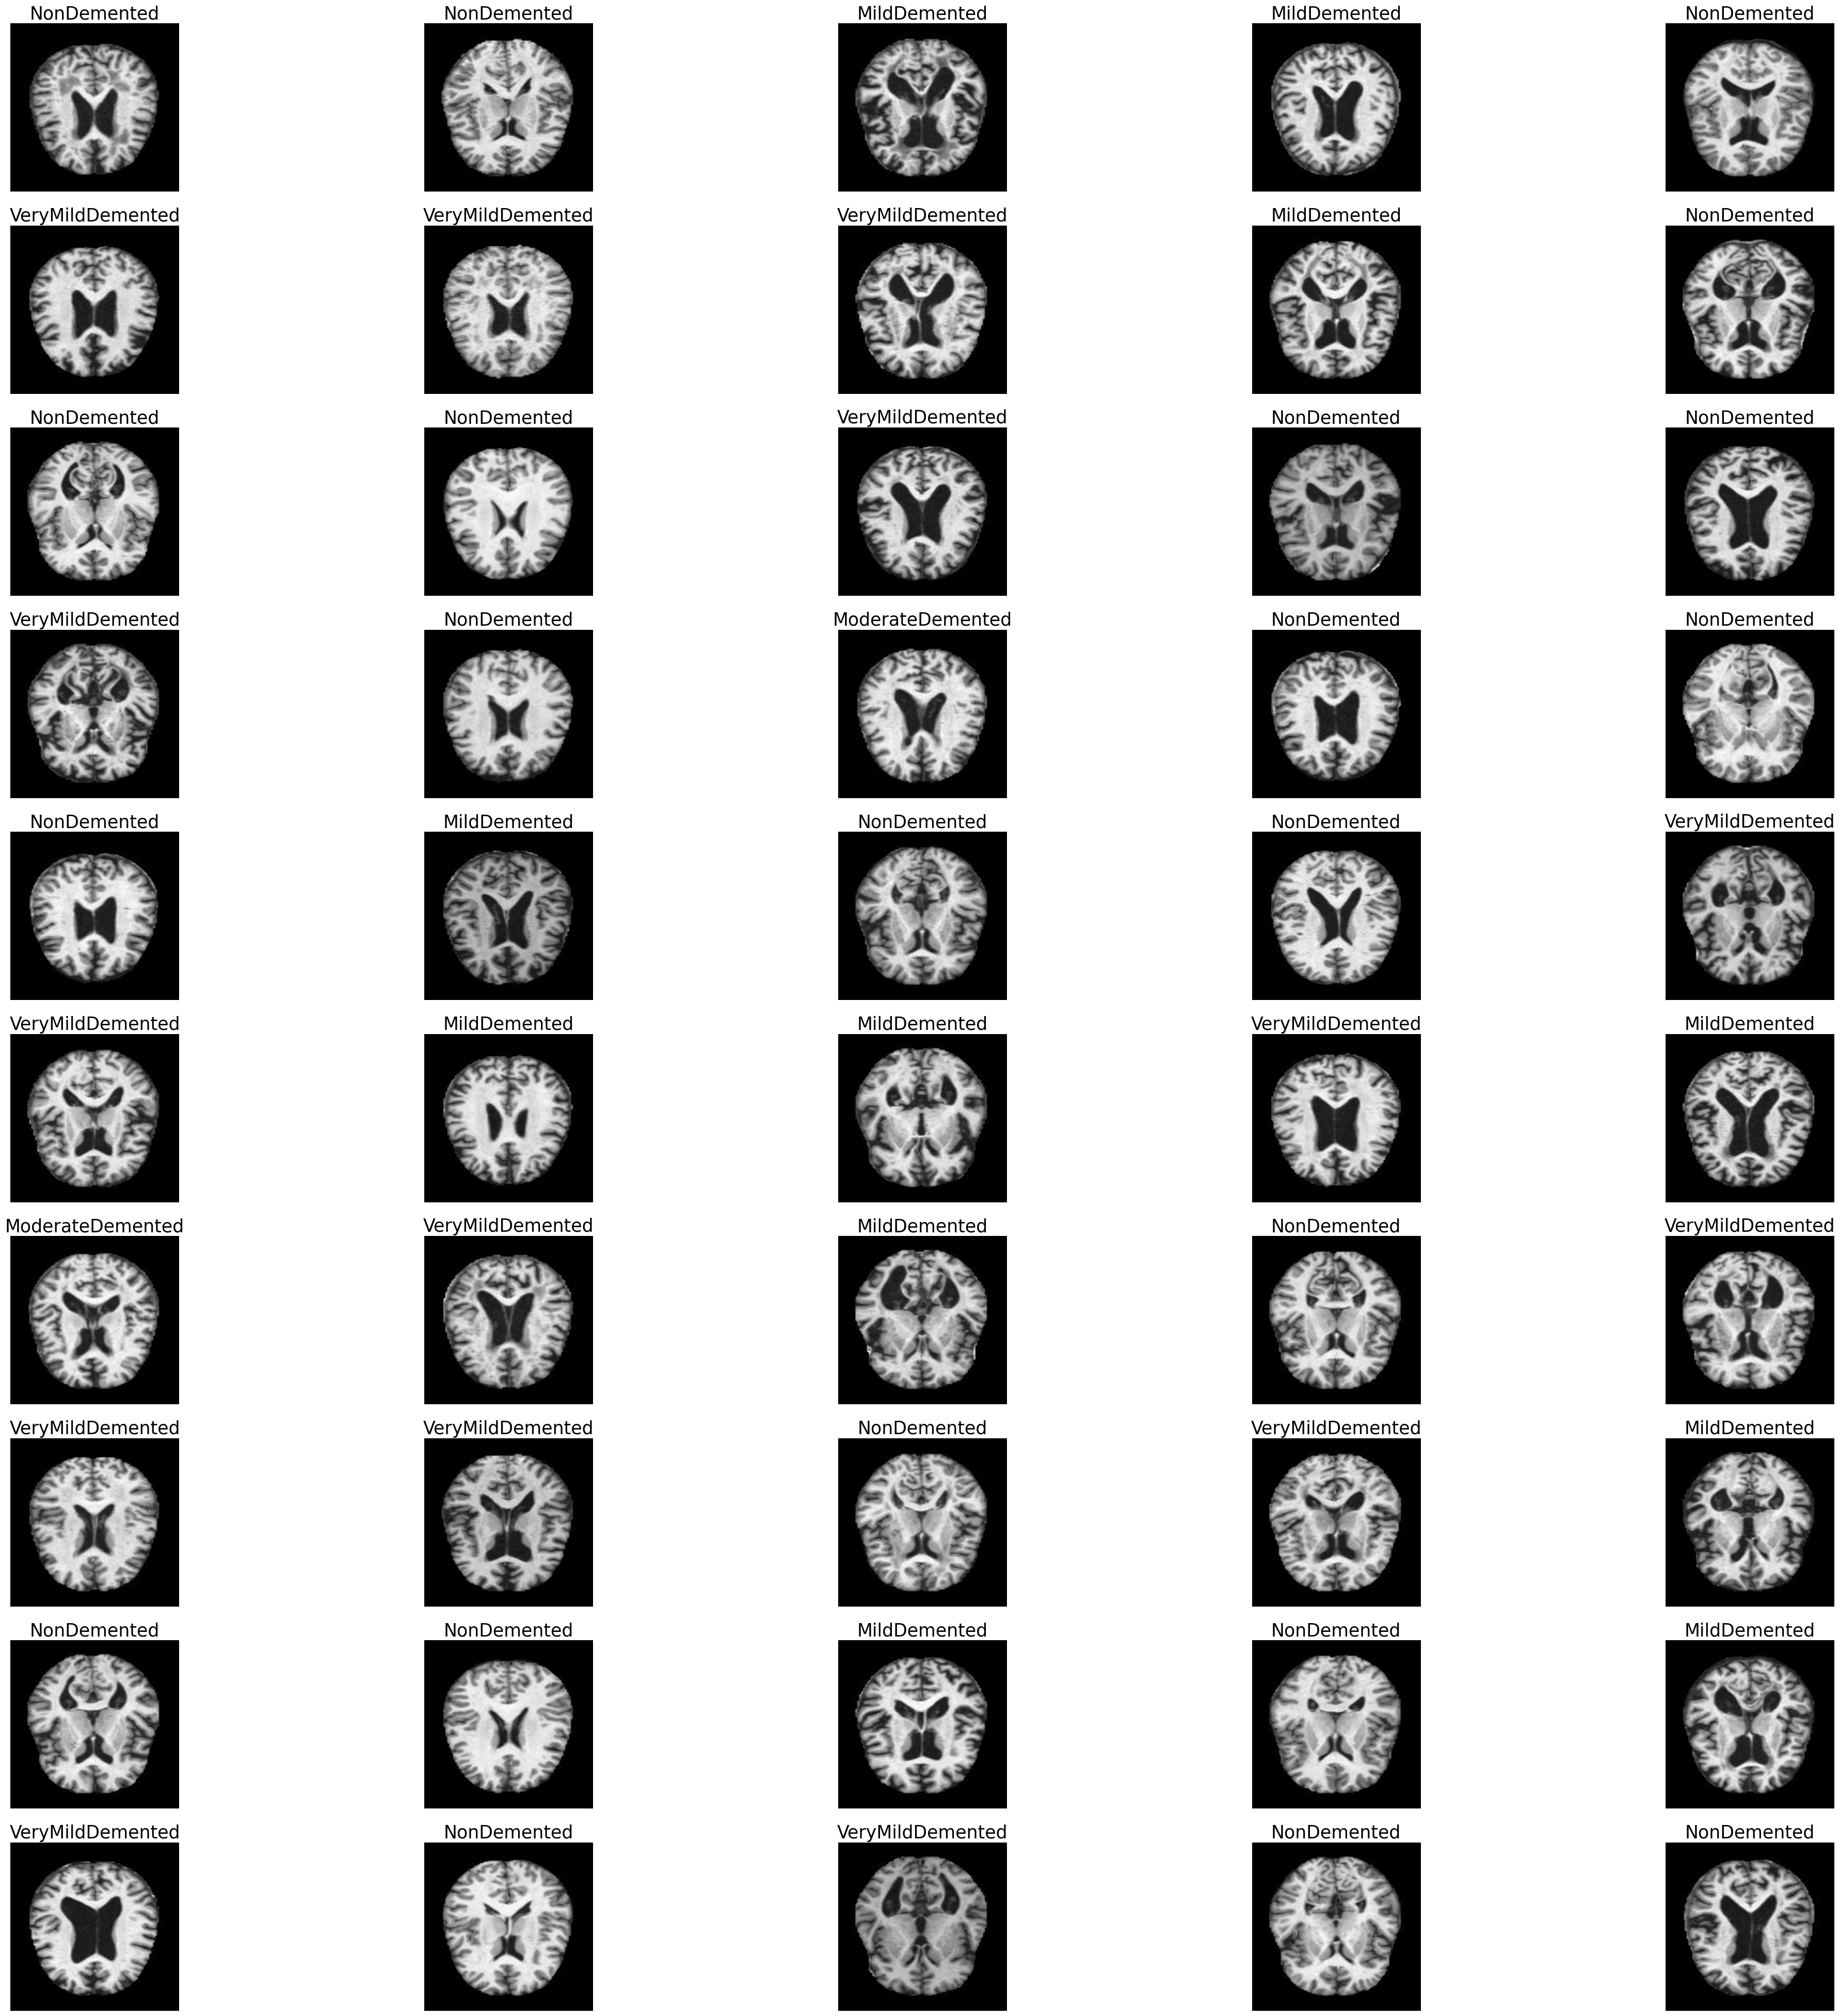

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Исследование данных</p>
<a class="btn" href="#home">Содержание</a>

In [5]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


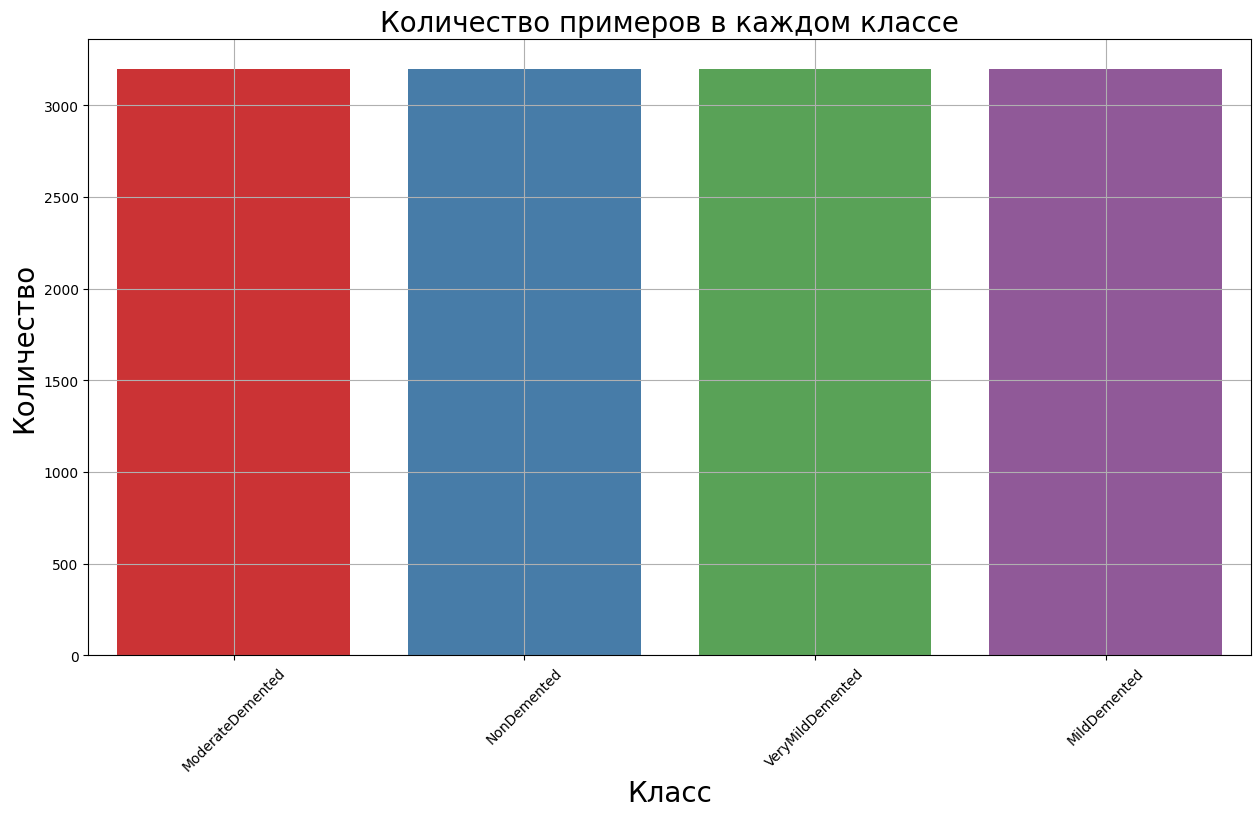

In [9]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Класс",fontsize=20)
ax.set_ylabel("Количество",fontsize=20)
plt.title('Количество примеров в каждом классе',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train форма ' , X_train.shape)
print('X_test форма ' , X_test.shape)
print('X_val форма ' , X_val.shape)
print('y_train форма ' , y_train.shape)
print('y_test форма ' , y_test.shape)
print('y_val форма ' , y_val.shape)

X_train форма  (8960, 176, 176, 3)
X_test форма  (1920, 176, 176, 3)
X_val форма  (1920, 176, 176, 3)
y_train форма  (8960, 4)
y_test форма  (1920, 4)
y_val форма  (1920, 4)


<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">InceptionV3 Модель </p>
<a class="btn" href="#home">Содержание</a>

In [11]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D()) 
model_Inception.add(keras.layers.Flatten()) 
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                         

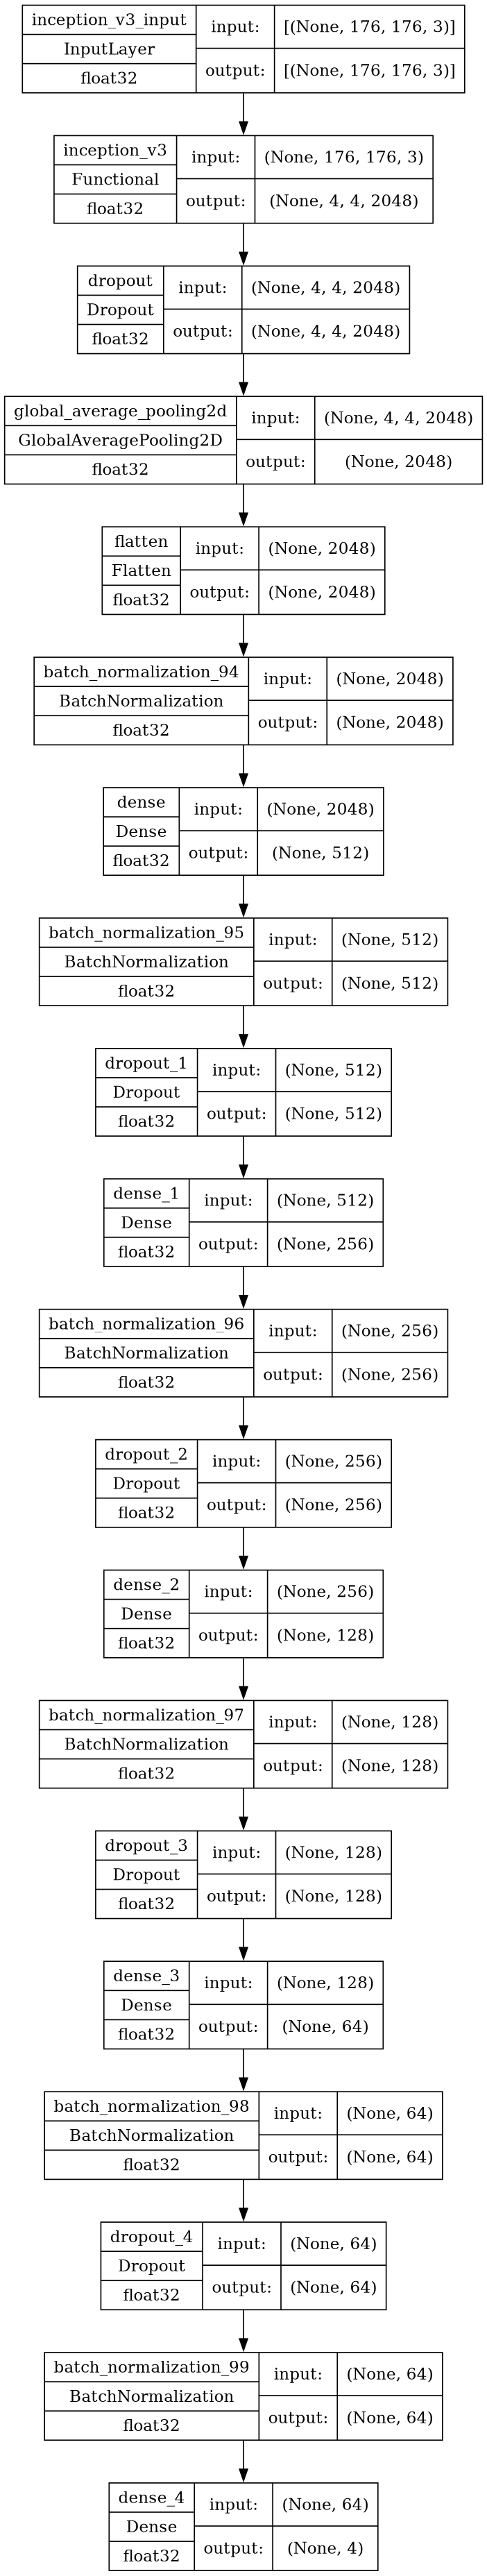

In [12]:
tf.keras.utils.plot_model(model_Inception, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [13]:
checkpoint_cb =ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model_Inception.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100


2024-04-12 10:12:19.537698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


280/280 [==============================] - ETA: 0s - loss: 1.3093 - accuracy: 0.4474

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 32s 72ms/step - loss: 1.3093 - accuracy: 0.4474 - val_loss: 0.7729 - val_accuracy: 0.6240
Epoch 2/100
280/280 [==============================] - 16s 58ms/step - loss: 0.9062 - accuracy: 0.5760 - val_loss: 0.6768 - val_accuracy: 0.6708
Epoch 3/100
280/280 [==============================] - 17s 59ms/step - loss: 0.7875 - accuracy: 0.6354 - val_loss: 0.6294 - val_accuracy: 0.6969
Epoch 4/100
280/280 [==============================] - 17s 60ms/step - loss: 0.7177 - accuracy: 0.6705 - val_loss: 0.5742 - val_accuracy: 0.7286
Epoch 5/100
280/280 [==============================] - 17s 61ms/step - loss: 0.6699 - accuracy: 0.6997 - val_loss: 0.5178 - val_accuracy: 0.7677
Epoch 6/100
280/280 [==============================] - 17s 62ms/step - loss: 0.6368 - accuracy: 0.7194 - val_loss: 0.4877 - val_accuracy: 0.7792
Epoch 7/100
280/280 [==============================] - 17s 62ms/step - loss: 0.5988 - accuracy: 0.7433 - val_loss: 0.4453 - val_accuracy: 0.79

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Оценка модели</p>
<a class="btn" href="#home">Содержание</a>

In [14]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   1.309317  0.447433  0.772936      0.623958
1   0.906189  0.576004  0.676791      0.670833
2   0.787461  0.635379  0.629422      0.696875
3   0.717695  0.670536  0.574183      0.728646
4   0.669937  0.699665  0.517766      0.767708
..       ...       ...       ...           ...
63  0.144759  0.950000  0.126786      0.952083
64  0.149461  0.949330  0.122527      0.954167
65  0.148417  0.950000  0.135879      0.950000
66  0.158227  0.946540  0.121267      0.954167
67  0.141309  0.950000  0.120789      0.955208

[68 rows x 4 columns]

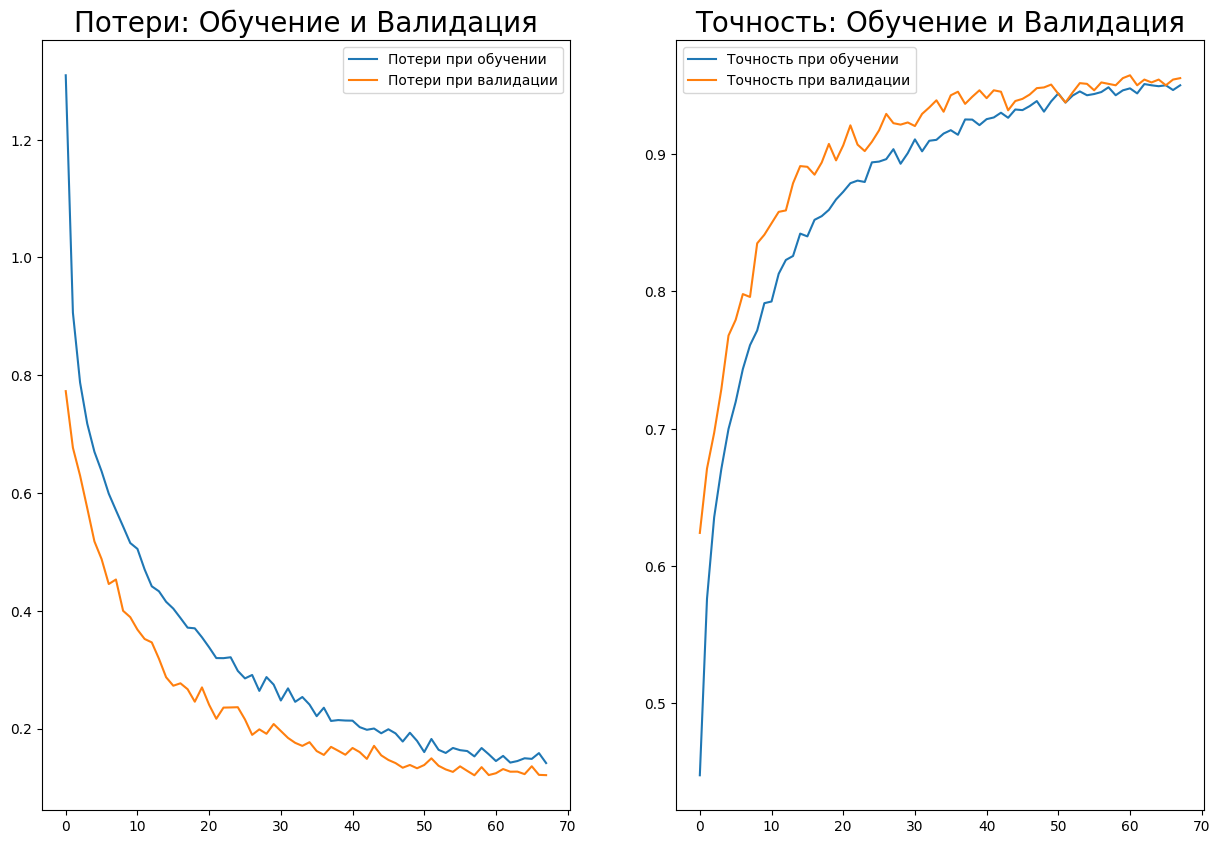

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Потери при обучении')
plt.plot(hist_['val_loss'],label='Потери при валидации')
plt.title('Потери: Обучение и Валидация',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Точность при обучении')
plt.plot(hist_['val_accuracy'],label='Точность при валидации')
plt.title('Точность: Обучение и Валидация',fontsize=20)
plt.legend()
plt.show()

In [16]:
score, acc= model_Inception.evaluate(X_test,y_test)
print('Потери тестирование =', score)
print('Точность тестирования =', acc)

60/60 [==============================] - 3s 43ms/step - loss: 0.1360 - accuracy: 0.9526
Потери тестирование = 0.13600954413414001
Точность тестирования = 0.9526041746139526


In [17]:
predictions = model_Inception.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'реальные': y_test_, 'прогноз': y_pred})
df

60/60 [==============================] - 4s 43ms/step


реальные  прогноз
0            1        1
1            1        1
2            0        0
3            2        2
4            2        2
...        ...      ...
1915         2        2
1916         0        0
1917         2        2
1918         3        3
1919         3        3

[1920 rows x 2 columns]

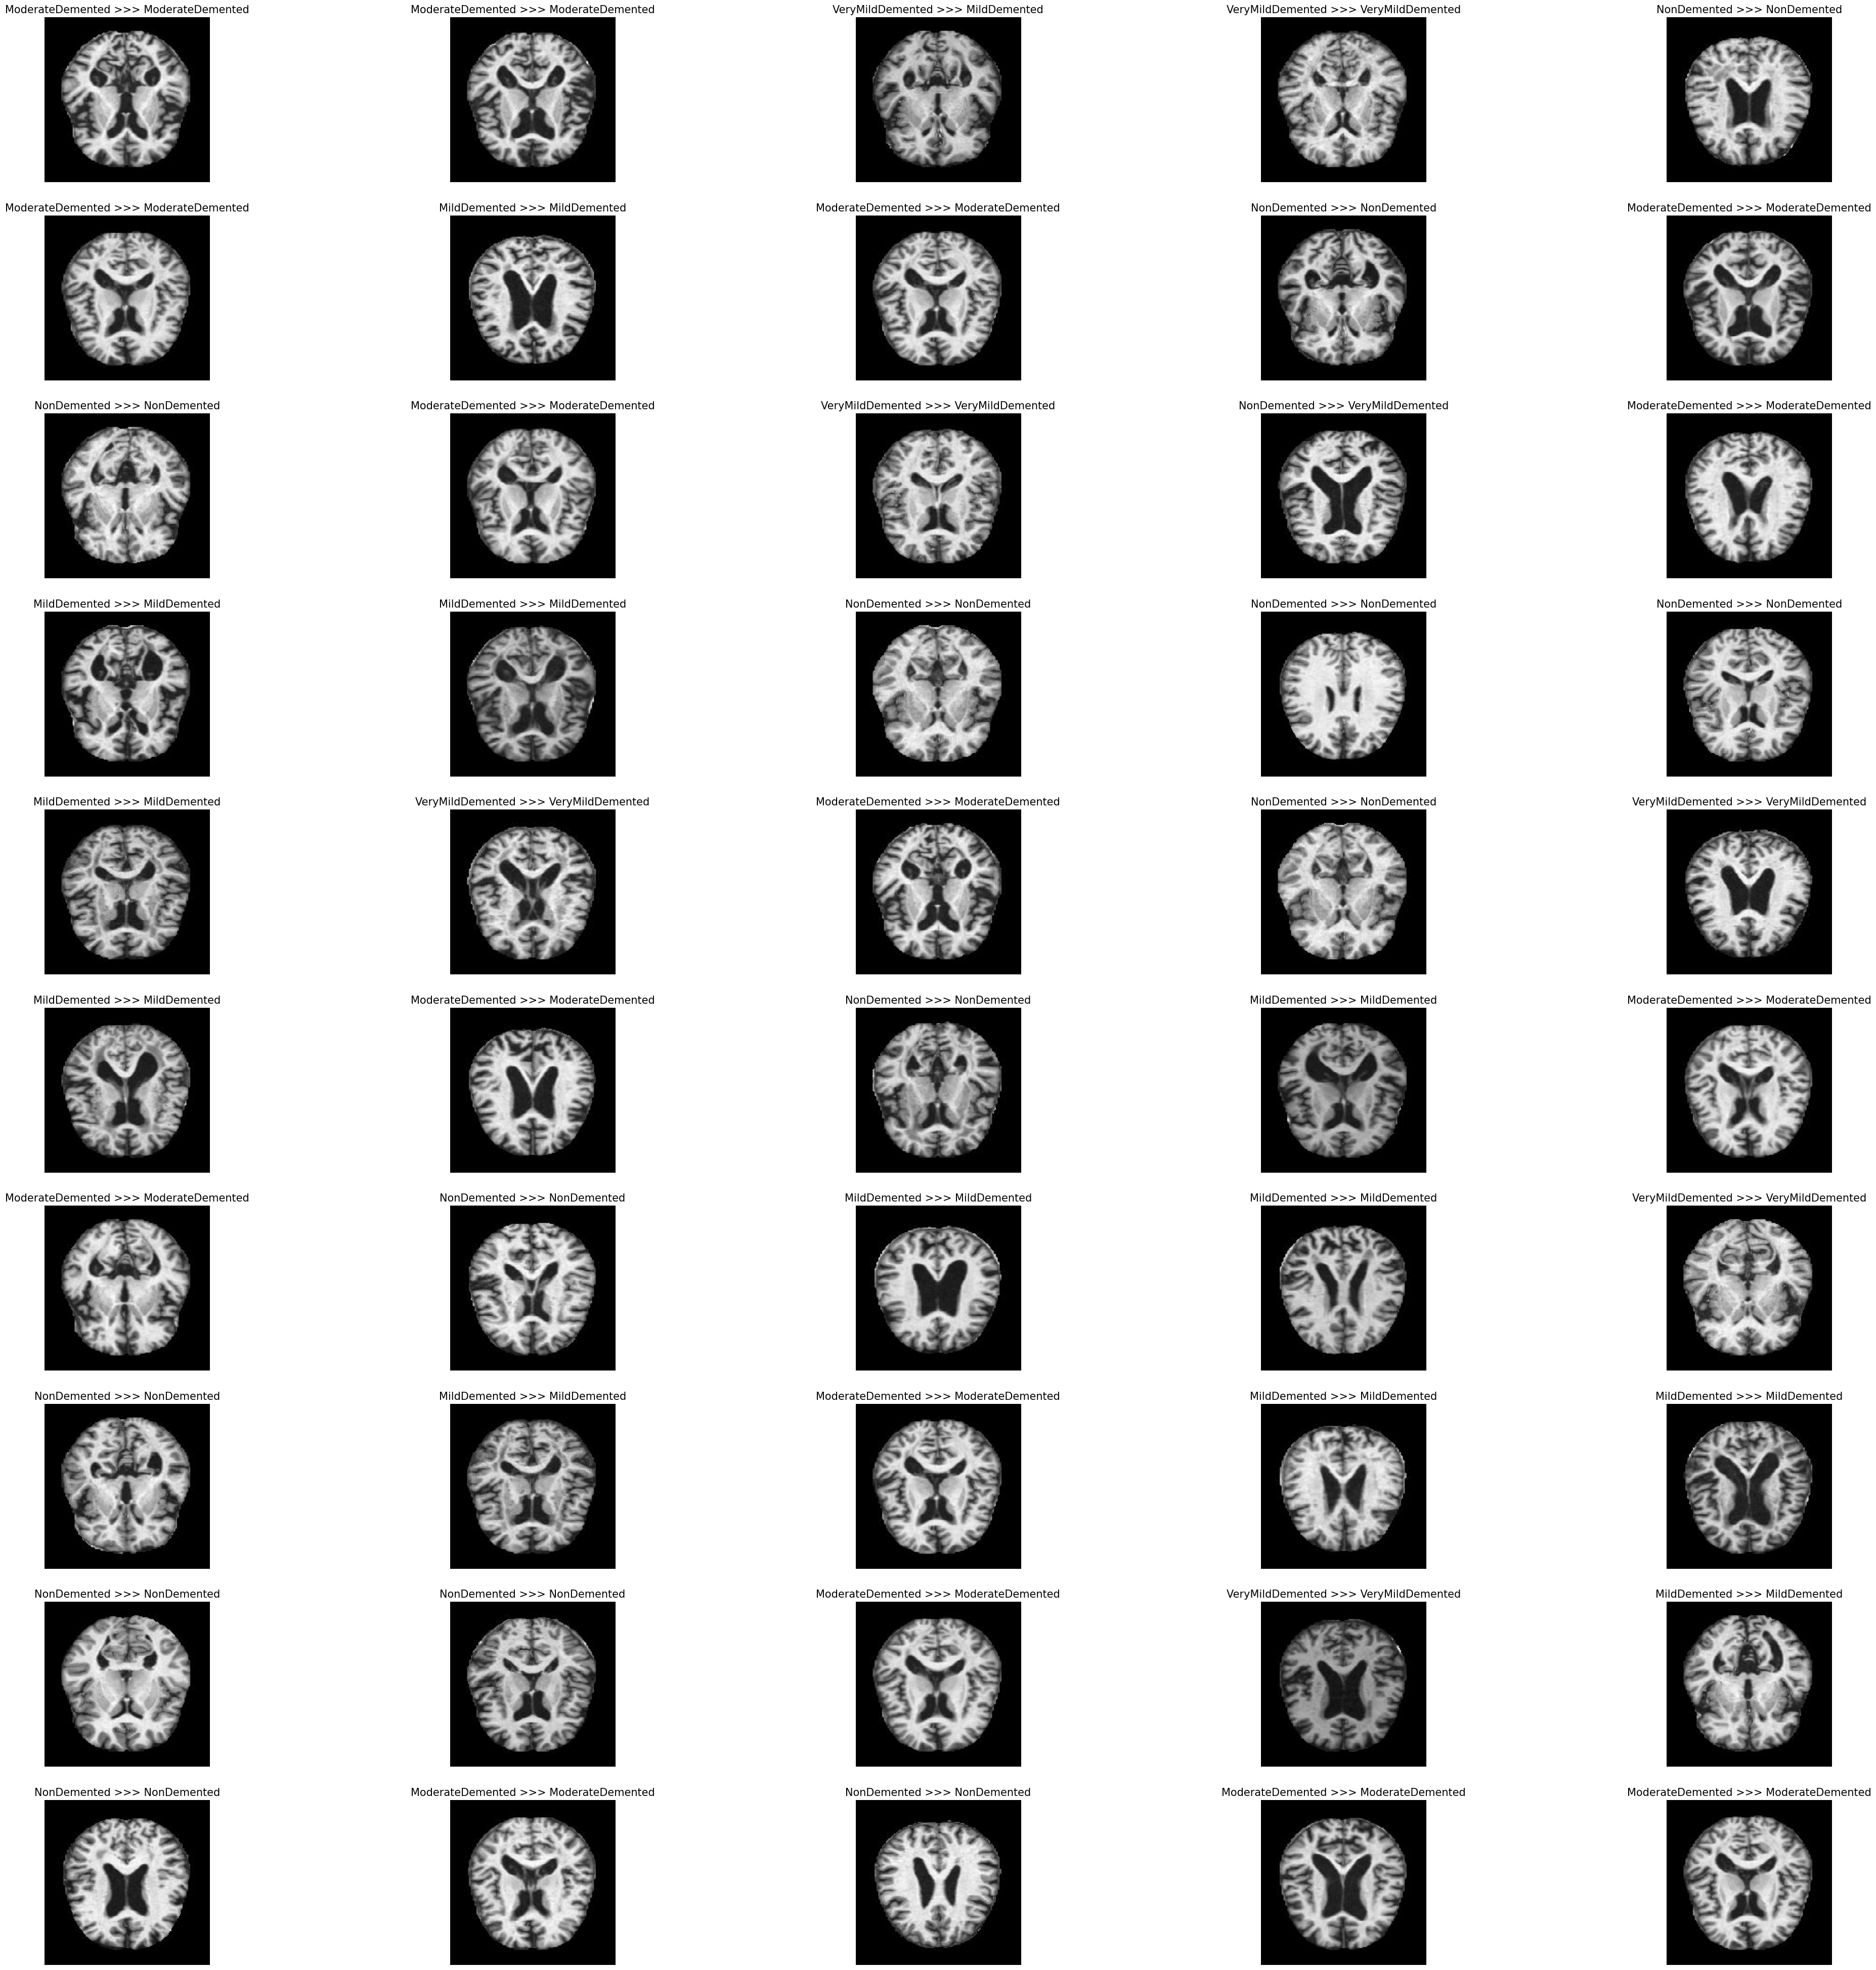

In [18]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[471,   0,   5,   4],
       [  0, 480,   0,   0],
       [  7,   0, 430,  43],
       [  9,   0,  23, 448]])

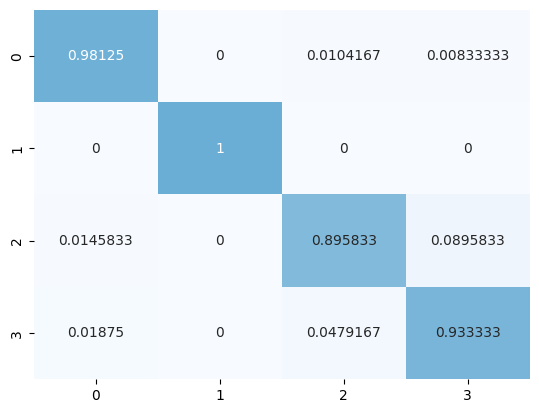

In [19]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [20]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Отчет по классификации: ', ClassificationReport )

Отчет по классификации:                precision    recall  f1-score   support

           0       0.97      0.98      0.97       480
           1       1.00      1.00      1.00       480
           2       0.94      0.90      0.92       480
           3       0.91      0.93      0.92       480

    accuracy                           0.95      1920
   macro avg       0.95      0.95      0.95      1920
weighted avg       0.95      0.95      0.95      1920

